## 1. Introduction
The given dataset contains sales records with 64.682 transactions and 22.625 customers IDs in 2016. The columns are Transaction, Customer ID, Transaction ID, Category, SKU, Quantity, and Sales Amount.

## 2. Objectives
The questions for this analysis are as follows.
1. What is the retention rate of the users in terms of the date since these users sign up.
2. Who are the top 5% frequency quantile with valid activity in 14 days? Who are the top 0.5% quantile in recency, frequency, and influence? Who are the top 10 most valuable users?
3. Who are the most valuable customers by using K-Means clustering?
4. The outcome difference between the k-means clustering and the linear quantile method.

## 3. Method
- Python
The structure of this analysis would be split into two major chapters. The first section is to cluster the customers by using a linear quantile method. In this way, it will be clear who purchase on certain days and how much they spend recently.

The second section is a k-mean clustering analysis. This method splits the customers into 3 different clusters in different criteria, recency, frequency, and monetary. In this way, there will be a group of selected people marked as the most important customers for this business.

Lastly, this analysis campares the outcomes from the linear quantile method and the k-mean clustering method. There is a difference between these two methods to achieve customer segmentation.

## 4. Prepare
- First of all, First of all, import functions that will be used and take a look at the dataset.

In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/retail-store-sales-transactions/scanner_data.csv


In [2]:
from datetime import timedelta
import matplotlib.dates as mdates
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [3]:
data = pd.read_csv('../input/retail-store-sales-transactions/scanner_data.csv')
data

,Unnamed: 0,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
0,1,02/01/2016,2547,1,X52,0EM7L,1.0,3.13
1,2,02/01/2016,822,2,2ML,68BRQ,1.0,5.46
2,3,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35
3,4,02/01/2016,3719,4,0H2,549KK,1.0,5.59
4,5,02/01/2016,9200,5,0H2,K8EHH,1.0,6.88
...,...,...,...,...,...,...,...,...
131701,131702,04/07/2016,20203,32900,IEV,FO112,3.0,6.46
131702,131703,04/07/2016,20203,32900,N8U,I36F2,1.0,4.50
131703,131704,04/07/2016,20203,32900,U5F,4X8P4,1.0,5.19
131704,131705,04/07/2016,20203,32900,0H2,ZVTO4,1.0,4.57


## 5. Process
- Determine whether there is an null value in the dataset.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131706 entries, 0 to 131705
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      131706 non-null  int64  
 1   Date            131706 non-null  object 
 2   Customer_ID     131706 non-null  int64  
 3   Transaction_ID  131706 non-null  int64  
 4   SKU_Category    131706 non-null  object 
 5   SKU             131706 non-null  object 
 6   Quantity        131706 non-null  float64
 7   Sales_Amount    131706 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 8.0+ MB


## 6. Analyze
- Calculate the duration month

In [5]:
def get_day(x): 
    return dt.datetime(x.year, x.month, x.day)

def get_month(x):
    return dt.datetime(x.year, x.month, 1)

data['Date']= pd.to_datetime(data['Date'])
data['invoice_date'] = data['Date'].apply(get_day)
group_invoice = data.groupby('Customer_ID')['invoice_date']
data['first_date'] = group_invoice.transform('min')
data['last_date'] = group_invoice.transform('max')
data['invoice_month'] = data['Date'].apply(get_month)
group_month = data.groupby('Customer_ID')['invoice_date']
data['first_month'] = group_month.transform('min').apply(get_month)
data.head()

,Unnamed: 0,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount,invoice_date,first_date,last_date,invoice_month,first_month
0,1,2016-02-01,2547,1,X52,0EM7L,1.0,3.13,2016-02-01,2016-01-25,2016-11-04,2016-02-01,2016-01-01
1,2,2016-02-01,822,2,2ML,68BRQ,1.0,5.46,2016-02-01,2016-01-30,2016-03-02,2016-02-01,2016-01-01
2,3,2016-02-01,3686,3,0H2,CZUZX,1.0,6.35,2016-02-01,2016-01-14,2016-11-01,2016-02-01,2016-01-01
3,4,2016-02-01,3719,4,0H2,549KK,1.0,5.59,2016-02-01,2016-01-14,2016-12-01,2016-02-01,2016-01-01
4,5,2016-02-01,9200,5,0H2,K8EHH,1.0,6.88,2016-02-01,2016-02-01,2016-09-04,2016-02-01,2016-02-01


In [6]:
def get_ymd (df, column):
    year=df[column].dt.year
    month=df[column].dt.month
    day=df[column].dt.day
    return year, month, day

invoice_year, invoice_month, _ = get_ymd(data, 'invoice_date')
first_year, first_month, _ = get_ymd(data, 'first_date')

years_diff = invoice_year - first_year
months_diff = invoice_month - first_month

data['duration_month'] = years_diff * 12 + months_diff * 1 + 1
data.head()

,Unnamed: 0,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount,invoice_date,first_date,last_date,invoice_month,first_month,duration_month
0,1,2016-02-01,2547,1,X52,0EM7L,1.0,3.13,2016-02-01,2016-01-25,2016-11-04,2016-02-01,2016-01-01,2
1,2,2016-02-01,822,2,2ML,68BRQ,1.0,5.46,2016-02-01,2016-01-30,2016-03-02,2016-02-01,2016-01-01,2
2,3,2016-02-01,3686,3,0H2,CZUZX,1.0,6.35,2016-02-01,2016-01-14,2016-11-01,2016-02-01,2016-01-01,2
3,4,2016-02-01,3719,4,0H2,549KK,1.0,5.59,2016-02-01,2016-01-14,2016-12-01,2016-02-01,2016-01-01,2
4,5,2016-02-01,9200,5,0H2,K8EHH,1.0,6.88,2016-02-01,2016-02-01,2016-09-04,2016-02-01,2016-02-01,1


In [7]:
group_cohort = data.groupby(['first_month','duration_month'])
cohort_data = group_cohort['Customer_ID'].apply(pd.Series.nunique).reset_index()
cohort_data

,first_month,duration_month,Customer_ID
0,2016-01-01,1,3817
1,2016-01-01,2,1104
2,2016-01-01,3,971
3,2016-01-01,4,899
4,2016-01-01,5,823
...,...,...,...
73,2016-10-01,2,112
74,2016-10-01,3,134
75,2016-11-01,1,1134
76,2016-11-01,2,100


- Get the number of users in terms of how many month they have been with valid activities. Then, generate the matrix by using a pivot table.

In [8]:
cohort_counts = cohort_data.pivot(index='first_month', columns='duration_month', values='Customer_ID')
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.round(4)*100

duration_month,1,2,3,4,5,6,7,8,9,10,11,12
first_month,,,,,,,,,,,,
2016-01-01,100.0,28.92,25.44,23.55,21.56,18.26,18.81,18.94,18.37,16.64,18.26,18.76
2016-02-01,100.0,19.93,18.67,18.52,15.80,15.22,16.09,16.56,16.24,16.78,15.77,NaN
2016-03-01,100.0,21.69,20.31,18.29,18.17,17.41,17.91,17.79,17.53,19.28,NaN,NaN
2016-04-01,100.0,19.02,17.41,15.97,16.06,18.15,15.84,17.06,16.97,NaN,NaN,NaN
2016-05-01,100.0,14.45,14.40,13.39,14.72,15.41,14.22,14.91,NaN,NaN,NaN,NaN
2016-06-01,100.0,11.69,12.72,14.11,13.07,13.35,14.45,NaN,NaN,NaN,NaN,NaN
2016-07-01,100.0,10.34,11.15,12.04,10.34,12.76,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-01,100.0,10.97,9.53,9.37,9.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-01,100.0,13.19,11.52,12.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Plot a heatmap to visualize the retention rates in terms of the dutation and the date that the account is created.

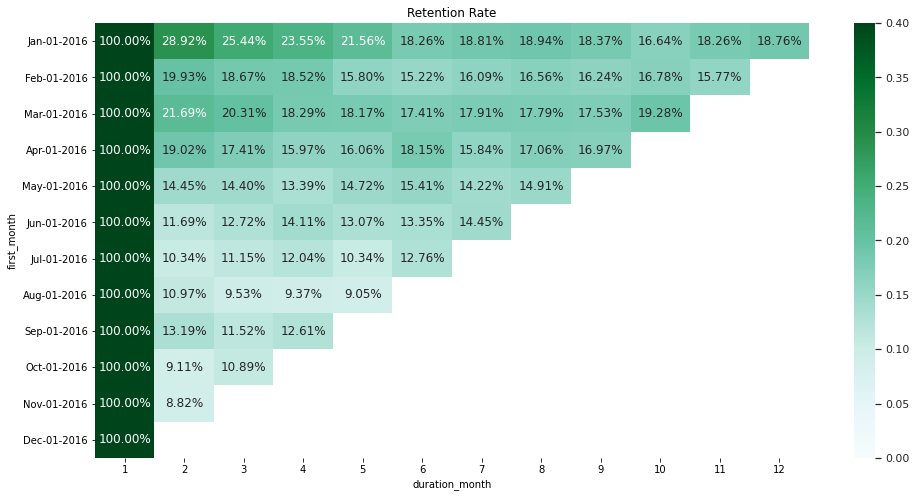

In [9]:
pd.to_datetime(retention.index)
plt.subplots(figsize=(16, 8))
sns.set()
ax = sns.heatmap(data=retention, annot=True, fmt='.2%', vmin=0.0, vmax=0.4, cmap='BuGn')
ax.set_yticklabels(retention.iloc[:].index.strftime('%b-%d-%Y'))
plt.yticks()
plt.title('Retention Rate')
plt.show()

- Figure out the average sales amount in terms of the customers splits into different duration months. Also, plot a heatmap to easily understand the situation.

In [10]:
group_sales = data.groupby(['first_month','duration_month']) 
cohort_sales = group_sales['Sales_Amount'].mean()
cohort_sales = cohort_sales.reset_index()
average_sales = cohort_sales.pivot(index='first_month', columns='duration_month', values='Sales_Amount')
average_sales.round(2)

duration_month,1,2,3,4,5,6,7,8,9,10,11,12
first_month,,,,,,,,,,,,
2016-01-01,11.60,12.51,12.15,12.55,12.22,12.53,12.22,11.27,12.29,11.79,11.92,12.65
2016-02-01,11.36,12.98,13.46,12.16,12.56,13.78,12.62,12.99,12.38,12.17,12.77,NaN
2016-03-01,11.62,12.93,12.12,13.02,12.38,12.90,12.32,12.55,12.74,12.82,NaN,NaN
2016-04-01,11.17,11.80,13.04,12.83,12.46,11.74,11.55,11.01,13.23,NaN,NaN,NaN
2016-05-01,11.38,11.46,12.88,12.34,13.30,11.79,12.66,12.69,NaN,NaN,NaN,NaN
2016-06-01,10.94,11.57,11.00,10.55,11.97,13.15,11.41,NaN,NaN,NaN,NaN,NaN
2016-07-01,11.11,11.81,12.61,12.13,11.46,11.94,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-01,11.62,13.87,12.56,11.84,13.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-01,11.26,11.57,10.82,12.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


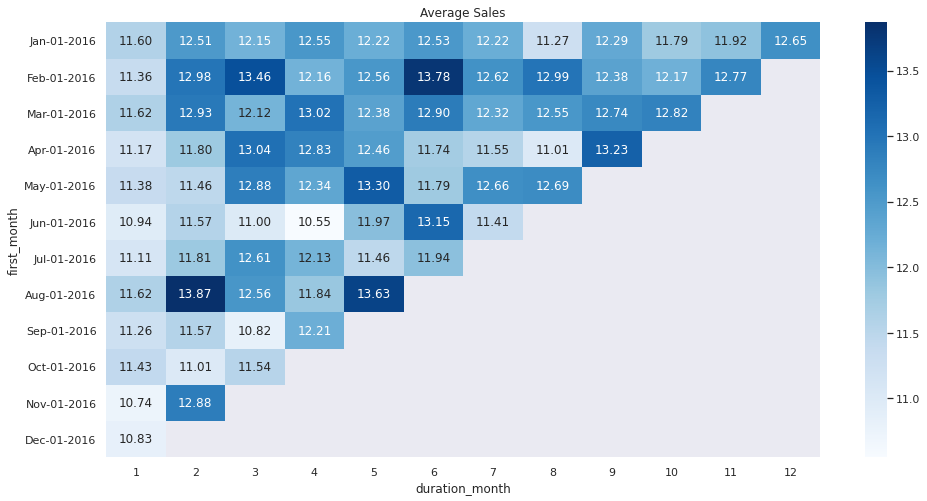

In [11]:
pd.to_datetime(retention.index)
plt.subplots(figsize=(16, 8))
sns.set()
ax = sns.heatmap(data=average_sales, annot=True, fmt='.2f',cmap='Blues')
ax.set_yticklabels(retention.iloc[:].index.strftime('%b-%d-%Y'))
plt.yticks()
plt.title('Average Sales')
plt.show()

In [12]:
data

,Unnamed: 0,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount,invoice_date,first_date,last_date,invoice_month,first_month,duration_month
0,1,2016-02-01,2547,1,X52,0EM7L,1.0,3.13,2016-02-01,2016-01-25,2016-11-04,2016-02-01,2016-01-01,2
1,2,2016-02-01,822,2,2ML,68BRQ,1.0,5.46,2016-02-01,2016-01-30,2016-03-02,2016-02-01,2016-01-01,2
2,3,2016-02-01,3686,3,0H2,CZUZX,1.0,6.35,2016-02-01,2016-01-14,2016-11-01,2016-02-01,2016-01-01,2
3,4,2016-02-01,3719,4,0H2,549KK,1.0,5.59,2016-02-01,2016-01-14,2016-12-01,2016-02-01,2016-01-01,2
4,5,2016-02-01,9200,5,0H2,K8EHH,1.0,6.88,2016-02-01,2016-02-01,2016-09-04,2016-02-01,2016-02-01,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131701,131702,2016-04-07,20203,32900,IEV,FO112,3.0,6.46,2016-04-07,2016-04-07,2016-10-24,2016-04-01,2016-04-01,1
131702,131703,2016-04-07,20203,32900,N8U,I36F2,1.0,4.50,2016-04-07,2016-04-07,2016-10-24,2016-04-01,2016-04-01,1
131703,131704,2016-04-07,20203,32900,U5F,4X8P4,1.0,5.19,2016-04-07,2016-04-07,2016-10-24,2016-04-01,2016-04-01,1
131704,131705,2016-04-07,20203,32900,0H2,ZVTO4,1.0,4.57,2016-04-07,2016-04-07,2016-10-24,2016-04-01,2016-04-01,1


- Make sure the last date of the last transaction. The last date is Dec 31st, 2016. Thus, here is to set Jan 1st, 2017, as the date of this analysis is processing in order to calculate the recency. (The lower recency, the better)

In [13]:
print(data['invoice_date'].min())
print(data['invoice_date'].max())

2016-01-02 00:00:00
2016-12-31 00:00:00


In [14]:
def get_ymd (df, column):
    year=df[column].dt.year
    month=df[column].dt.month
    day=df[column].dt.day
    return year, month, day

last_year, last_month, last_day = get_ymd(data, 'last_date')

years_diff_last = 2016 - last_year
months_diff_last = 12 - last_month
days_diff_last = 31 - last_day

data['recency'] = years_diff_last * 365 + months_diff_last * 30 + days_diff_last + 1
data.head()

,Unnamed: 0,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount,invoice_date,first_date,last_date,invoice_month,first_month,duration_month,recency
0,1,2016-02-01,2547,1,X52,0EM7L,1.0,3.13,2016-02-01,2016-01-25,2016-11-04,2016-02-01,2016-01-01,2,58
1,2,2016-02-01,822,2,2ML,68BRQ,1.0,5.46,2016-02-01,2016-01-30,2016-03-02,2016-02-01,2016-01-01,2,300
2,3,2016-02-01,3686,3,0H2,CZUZX,1.0,6.35,2016-02-01,2016-01-14,2016-11-01,2016-02-01,2016-01-01,2,61
3,4,2016-02-01,3719,4,0H2,549KK,1.0,5.59,2016-02-01,2016-01-14,2016-12-01,2016-02-01,2016-01-01,2,31
4,5,2016-02-01,9200,5,0H2,K8EHH,1.0,6.88,2016-02-01,2016-02-01,2016-09-04,2016-02-01,2016-02-01,1,118


- Generate a new dataframe for recency, frequency, and monetary.

In [15]:
data_recency=data.groupby('Customer_ID')['recency'].apply(min).reset_index()
data_frequency=data.groupby('Customer_ID').size().reset_index(name='count')
data_monetary=data.groupby('Customer_ID')['Sales_Amount'].apply(sum).reset_index()

data_rf = pd.merge(left=data_recency, right=data_frequency, how='inner', left_on='Customer_ID', right_on='Customer_ID')
data_rfm = pd.merge(left=data_rf, right=data_monetary, how='inner', left_on='Customer_ID', right_on='Customer_ID')
data_rfm.rename(columns={'count': 'frequency', 'Sales_Amount': 'monetary'}, inplace=True)
data_rfm = data_rfm.set_index('Customer_ID')
data_rfm

,recency,frequency,monetary
Customer_ID,,,
1,340,2,16.29
2,193,2,22.77
3,331,3,10.92
4,55,5,33.29
5,120,5,78.82
...,...,...,...
22621,80,2,9.69
22622,16,1,6.07
22623,11,2,128.01


- Here is to subset the data by the top 20% frequency quantile and the last activity in 2 weeks. The total number of customers in this group is 1,108.

In [16]:
print('Top 20% shopping frequency quantile:', data_rfm['frequency'].quantile(q = 0.8))

data_rfm['frequency'].quantile(q = 0.8)
data_20qf = data_rfm[data_rfm['frequency'] >= data_rfm['frequency'].quantile(q = 0.8)]
data_20qf_14d=data_20qf[data_20qf['recency']<=14]
data_20qf_14d

Top 20% shopping frequency quantile: 7.0


,recency,frequency,monetary
Customer_ID,,,
1659,11,22,222.10
1660,1,228,1429.91
1662,9,12,174.82
1665,3,222,1842.65
1666,1,109,679.19
...,...,...,...
22410,2,18,189.75
22457,9,8,72.40
22482,4,8,61.77


- Visualize the data to quickly view the distribution of these 1,108 customers.

In [17]:
fig=go.Figure()
fig.add_trace(
    go.Scatter(x=data_rfm['frequency'], y=data_rfm['monetary'], name='All customers', mode='markers', opacity=0.5)
)
fig.add_trace(
    go.Scatter(x=data_20qf_14d['frequency'], y=data_20qf_14d['monetary'], name='Top 20% frequency purchasing in 14 days', mode='markers')
)
fig.update_layout({  
      'showlegend':True, 'legend':{'x':0.02, 'y':0.96, 'bgcolor':'rgb(246, 228, 129)'}
      })
fig.update_xaxes(
        title_text = "Purchase Frequency",
        title_font = {"size": 16},
        title_standoff = 12)
fig.update_yaxes(
        title_text = "Monetary",
        title_font = {"size": 16},
        title_standoff = 12)
fig.show()

- Here is to subset the data by the top 5% quantile in recency, frequency, and monetary. The total number of these customers is 224.

In [18]:
print('Top 5% recency quantile:', data_rfm['recency'].quantile(q = 0.05))
print('Top 5% shopping frequency quantile:', data_rfm['frequency'].quantile(q = 0.95))
print('Top 5% purchase amount quantile:', data_rfm['monetary'].quantile(q = 0.95))

sel_data_5qr = data_rfm['recency'] <= data_rfm['recency'].quantile(q = 0.05)
sel_data_5qf = data_rfm['frequency'] >= data_rfm['frequency'].quantile(q = 0.95)
sel_data_5qm = data_rfm['monetary'] >= data_rfm['monetary'].quantile(q = 0.95)
data_5rfm = data_rfm[sel_data_5qr & sel_data_5qf & sel_data_5qm]
data_5rfm

Top 5% recency quantile: 10.0
Top 5% shopping frequency quantile: 21.0
Top 5% purchase amount quantile: 287.25599999999935


,recency,frequency,monetary
Customer_ID,,,
1660,1,228,1429.91
1665,3,222,1842.65
1666,1,109,679.19
1694,3,123,1035.63
1702,2,112,1028.61
...,...,...,...
21104,2,24,460.09
21297,4,55,945.30
21667,9,28,405.50


- Again, visualize the data to see where these 752 customers are.

In [19]:
fig=go.Figure()
fig.add_trace(
    go.Scatter(x=data_rfm['frequency'], y=data_rfm['monetary'], name='All customers', mode='markers', opacity=0.5)
)
fig.add_trace(
    go.Scatter(x=data_5rfm['frequency'], y=data_5rfm['monetary'], name='Top 5% quantile in recency, frequency and spending', mode='markers')
)
fig.update_layout({  
      'showlegend':True, 'legend':{'x':0.02, 'y':0.96, 'bgcolor':'rgb(246, 228, 129)'}
      })
fig.update_xaxes(
        title_text = "Purchase Frequency",
        title_font = {"size": 16},
        title_standoff = 12)
fig.update_yaxes(
        title_text = "Monetary",
        title_font = {"size": 16},
        title_standoff = 12)
fig.show()

- Subset the data by the top 1% quantile in recency, frequency, and monetary to get 17 customers, and then sort the value by monetary to pick the top 10 valuable customers.

In [20]:
print('Top 1% recency quantile:', data_rfm['recency'].quantile(q = 0.01))
print('Top 1% shopping frequency quantile:', data_rfm['frequency'].quantile(q = 0.99))
print('Top 1% purchase amount quantile:', data_rfm['monetary'].quantile(q = 0.99))

sel_data_1qr = data_rfm['recency'] <= data_rfm['recency'].quantile(q = 0.01)
sel_data_1qf = data_rfm['frequency'] >= data_rfm['frequency'].quantile(q = 0.99)
sel_data_1qm = data_rfm['monetary'] >= data_rfm['monetary'].quantile(q = 0.99)
data_sel_rfm = data_rfm[sel_data_1qr & sel_data_1qf & sel_data_1qm]
data_sel_rfm

Top 1% recency quantile: 2.0
Top 1% shopping frequency quantile: 47.7599999999984
Top 1% purchase amount quantile: 743.2907999999986


,recency,frequency,monetary
Customer_ID,,,
1660,1,228,1429.91
1702,2,112,1028.61
2186,2,116,955.22
15491,2,75,760.26
15857,2,50,1002.88
15904,2,71,1485.44
15965,2,114,1563.10
17028,2,83,1063.42
17061,1,143,2057.69


In [21]:
data_top10 = data_sel_rfm.sort_values(by='monetary', ascending=False).head(10)
data_top10

,recency,frequency,monetary
Customer_ID,,,
17104,1,218,3844.97
17061,1,143,2057.69
17306,1,66,1690.49
15965,2,114,1563.10
17926,1,72,1515.32
15904,2,71,1485.44
1660,1,228,1429.91
18887,2,52,1427.39
17028,2,83,1063.42


- Point out the top 10 cutomers in a scatter plot

In [22]:
fig=go.Figure()
fig.add_trace(
    go.Scatter(x=data_rfm['frequency'], y=data_rfm['monetary'], name='All customers', mode='markers', opacity=0.3)
)
fig.add_trace(
    go.Scatter(x=data_top10['frequency'], y=data_top10['monetary'], name='Top 10 Customers', mode='markers')
)

annotaion_01={'x':'218', 'y':'3844.97', 'showarrow':True, 'arrowhead':4, 'xshift':-2,'yshift':8,'text':'ID-17450', 'textangle':-90, 'font':{'size':10, 'color':'green'}}
annotaion_02={'x':'143', 'y':'2057.69', 'showarrow':True, 'arrowhead':4, 'xshift':-2,'yshift':8,'text':'ID-16029', 'textangle':-90,'font':{'size':10, 'color':'green'}}
annotaion_03={'x':'66', 'y':'1690.49', 'showarrow':True, 'arrowhead':4, 'xshift':-2,'yshift':8,'text':'ID-13694', 'textangle':-90,'font':{'size':10, 'color':'green'}}
annotaion_04={'x':'114', 'y':'1563.10', 'showarrow':True, 'arrowhead':4, 'xshift':-2,'yshift':8,'text':'ID-13089', 'textangle':-90,'font':{'size':10, 'color':'green'}}
annotaion_05={'x':'72', 'y':'1515.32', 'showarrow':True, 'arrowhead':4, 'xshift':-2,'yshift':8,'text':'ID-17949', 'textangle':-90,'font':{'size':10, 'color':'green'}}
annotaion_06={'x':'71', 'y':'1485.44', 'showarrow':False, 'arrowhead':4, 'xshift':0,'yshift':-30,'text':'ID-15061', 'textangle':-90,'font':{'size':10, 'color':'green'}}
annotaion_07={'x':'228', 'y':'1429.91', 'showarrow':False, 'arrowhead':4, 'xshift':0,'yshift':-32,'text':'ID-14298', 'textangle':-90,'font':{'size':10, 'color':'green'}}
annotaion_08={'x':'52', 'y':'1427.39', 'showarrow':True, 'arrowhead':4, 'xshift':-2,'yshift':8,'text':'ID-17841', 'textangle':-90,'font':{'size':10, 'color':'green'}}
annotaion_09={'x':'83', 'y':'1063.42', 'showarrow':True, 'arrowhead':4, 'xshift':-2,'yshift':8,'text':'ID-13798', 'textangle':-90,'font':{'size':10, 'color':'green'}}
annotaion_10={'x':'112', 'y':'1028.61', 'showarrow':False, 'arrowhead':4, 'xshift':0,'yshift':-32,'text':'ID-16422', 'textangle':-90,'font':{'size':10, 'color':'green'}}

fig.update_layout({ 
    'annotations':[annotaion_01, annotaion_02, annotaion_03,
      annotaion_04, annotaion_05, annotaion_06,
      annotaion_07, annotaion_08, annotaion_09, annotaion_10], 
      'showlegend':True, 'legend':{'x':0.02, 'y':0.96, 'bgcolor':'rgb(246, 228, 129)'}
      })
fig.update_xaxes(
        title_text = "Purchase Frequency",
        title_font = {"size": 16},
        title_standoff = 12)
fig.update_yaxes(
        title_text = "Monetary",
        title_font = {"size": 16},
        title_standoff = 12)
fig.show()

- K-Means clustering analysis starts from here. First, splits the customers into 3 levels to quickly review the numbers of these 3 levels.

In [23]:
range_labels = list(range(3, 0, -1))
data_q=data_rfm.copy(deep=True)
data_q['recency_quartile']=pd.qcut(data_q['recency'].rank(method='first'), q=3, labels=range_labels)
data_q['frequency_quartile']=pd.qcut(data_q['frequency'].rank(method='first'), q=3, labels=range(1,4))
data_q['monetary_quartile']=pd.qcut(data_q['monetary'].rank(method='first'), q=3, labels=range(1,4))
data_q.head()

,recency,frequency,monetary,recency_quartile,frequency_quartile,monetary_quartile
Customer_ID,,,,,,
1,340,2,16.29,1,1,2
2,193,2,22.77,2,1,2
3,331,3,10.92,1,2,1
4,55,5,33.29,3,2,2
5,120,5,78.82,2,2,3


In [24]:
data_cat = (data_q['recency_quartile'].astype(str)).str.cat(data_q['frequency_quartile'].astype(str))
data_q['rfm_segment']=data_cat.str.cat(data_q['monetary_quartile'].astype(str))
data_q.head()

,recency,frequency,monetary,recency_quartile,frequency_quartile,monetary_quartile,rfm_segment
Customer_ID,,,,,,,
1,340,2,16.29,1,1,2,112
2,193,2,22.77,2,1,2,212
3,331,3,10.92,1,2,1,121
4,55,5,33.29,3,2,2,322
5,120,5,78.82,2,2,3,223


- Sum up the scores to rank the customers into 3 levels, the Top, Middle, and Low levels.

In [25]:
data_q['rfm_score'] = data_q[['recency_quartile','frequency_quartile','monetary_quartile']].sum(axis=1)
data_q.head()

,recency,frequency,monetary,recency_quartile,frequency_quartile,monetary_quartile,rfm_segment,rfm_score
Customer_ID,,,,,,,,
1,340,2,16.29,1,1,2,112,4
2,193,2,22.77,2,1,2,212,5
3,331,3,10.92,1,2,1,121,4
4,55,5,33.29,3,2,2,322,7
5,120,5,78.82,2,2,3,223,7


In [26]:
def rfm_level(df):
    if df['rfm_score'] >= 7:
        return 'Top'
    elif ((df['rfm_score'] >= 4) and (df['rfm_score'] < 7)):
        return 'Middle'
    else:
        return 'Low'
data_q['rfm_level'] = data_q.apply(rfm_level, axis=1)
data_q.head()

,recency,frequency,monetary,recency_quartile,frequency_quartile,monetary_quartile,rfm_segment,rfm_score,rfm_level
Customer_ID,,,,,,,,,
1,340,2,16.29,1,1,2,112,4,Middle
2,193,2,22.77,2,1,2,212,5,Middle
3,331,3,10.92,1,2,1,121,4,Middle
4,55,5,33.29,3,2,2,322,7,Top
5,120,5,78.82,2,2,3,223,7,Top


- Here is to show the mean numbers of 3 criteria for the following comparison.

In [27]:
rfm_level_agg = data_q.groupby('rfm_level').agg({'recency': 'mean','frequency': 'mean', 'monetary': ['mean', 'count']
}).round(2)
rfm_level_agg.head()

recency frequency monetary       
             mean      mean     mean  count
rfm_level                                  
Low        281.64      1.14     6.76   2866
Middle     166.70      2.12    20.28  10324
Top         75.90     11.29   143.01   9435

- Because K-Means works well on variables with the same mean and standard diviation, here is normalizing the data and reviwing the key statistics to verify whehter the data is good to use.

In [28]:
scaler=StandardScaler()
scaler.fit(data_rfm)
data_normalized=scaler.transform(data_rfm)
data_normalized=pd.DataFrame(data_normalized, index=data_rfm.index, columns=data_rfm.columns)
print(data_normalized.describe().round(2))

        recency  frequency  monetary
count  22625.00   22625.00  22625.00
mean      -0.00      -0.00      0.00
std        1.00       1.00      1.00
min       -1.32      -0.49     -0.46
25%       -0.92      -0.49     -0.39
50%       -0.22      -0.29     -0.30
75%        0.89       0.02     -0.04
max        2.02      22.47     25.71


- Plot the distribution of the 3 subjects. As the graphics show, these numbers are highly skewed.

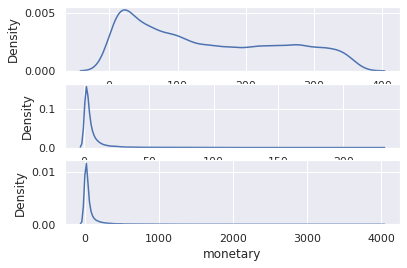

In [29]:
plt.subplot(3, 1, 1); sns.kdeplot(data_rfm['recency'])
plt.subplot(3, 1, 2); sns.kdeplot(data_rfm['frequency'])
plt.subplot(3, 1, 3); sns.kdeplot(data_rfm['monetary'])
plt.show()

- Get the log scale in order to get a better distribution.

In [30]:
data_log=np.log(data_rfm)
scaler=StandardScaler()
data_log.replace([np.inf, -np.inf], np.nan, inplace=True)
scaler.fit(data_log)
data_normalized=scaler.transform(data_log)
data_normalized = pd.DataFrame(data=data_normalized, index=data_log.index, columns=data_log.columns)
data_normalized.head()

,recency,frequency,monetary
Customer_ID,,,
1,1.121191,-0.450017,-0.368568
2,0.647167,-0.450017,-0.115912
3,1.098733,-0.048519,-0.670309
4,-0.403719,0.457308,0.170634
5,0.249368,0.457308,0.820891


In [31]:
data_normalized=data_normalized.fillna(0)
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(data_normalized)
cluster_labels = kmeans.labels_

data_rfm_k3 = data_rfm.assign(Cluster=cluster_labels)
grouped = data_rfm_k3.groupby(['Cluster'])

grouped.agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count']
  }).round(1)

recency frequency monetary       
           mean      mean     mean  count
Cluster                                  
0         154.2       5.2     60.3   8142
1         183.2       1.5     10.9  10221
2          27.3      17.6    229.0   4262

- Plot the log numbers to see the distribution. Although the log recency is still slightly skewed, frequency and monetary look better than before.

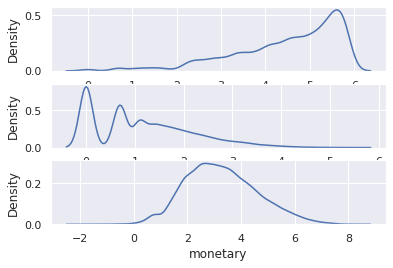

In [32]:
plt.subplot(3, 1, 1); sns.kdeplot(data_log['recency'])
plt.subplot(3, 1, 2); sns.kdeplot(data_log['frequency'])
plt.subplot(3, 1, 3); sns.kdeplot(data_log['monetary'])
plt.show()

- Running k-mean clustering on the normalized data. From the visulization, the elbow with a sharpest angel is the optimal number for clustering. Here shows 2 or 3 clusters is the optimal number.

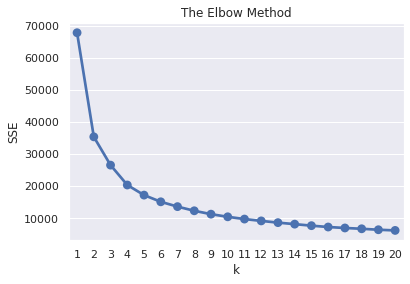

In [33]:
sse={}
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(data_normalized)
    sse[k] = kmeans.inertia_

sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()

- Add a 'Cluster' columns into the normalized datafram, and then melt the datafram into a long datafram by vertically stacking 3 subjects, recency, frequency, and monetry, one by one.

In [34]:
data_normalized['cluster']=data_rfm_k3['Cluster']
data_normalized.head()

,recency,frequency,monetary,cluster
Customer_ID,,,,
1,1.121191,-0.450017,-0.368568,1
2,0.647167,-0.450017,-0.115912,1
3,1.098733,-0.048519,-0.670309,1
4,-0.403719,0.457308,0.170634,0
5,0.249368,0.457308,0.820891,0


In [35]:
data_melt = pd.melt(
    data_normalized.reset_index(), 
    id_vars=['Customer_ID', 'cluster'],
    value_vars=['recency', 'frequency', 'monetary'], 
    var_name='metric', value_name='value'
)
data_melt.head()

,Customer_ID,cluster,metric,value
0,1,1,recency,1.121191
1,2,1,recency,0.647167
2,3,1,recency,1.098733
3,4,0,recency,-0.403719
4,5,0,recency,0.249368


- Plot a line chart to compare different clusters. Obviously, the cluster 2 has higher frequncy and monetary with short recency, which is much better than the others.

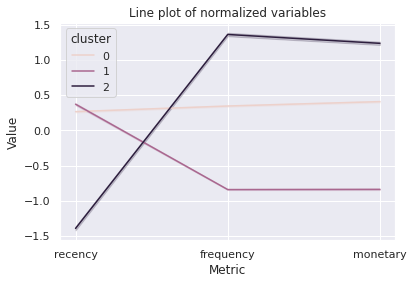

In [36]:
sns.lineplot(data=data_melt, x='metric', y='value', hue='cluster')
plt.title('Line plot of normalized variables')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.show()

- Identify the importance of each segment's attribute by calculating ratio beteen the average values of the clusters and the average of the population.

In [37]:
cluster_avg = data_rfm_k3.groupby(['Cluster']).mean() 
population_avg = data_rfm.mean()
relative_imp = cluster_avg / population_avg - 1
print(relative_imp.round(2))

         recency  frequency  monetary
Cluster                              
0           0.08      -0.11     -0.14
1           0.28      -0.75     -0.84
2          -0.81       2.02      2.28


- Plot a heat map to easily distinguash the most important cluster, cluster 2.

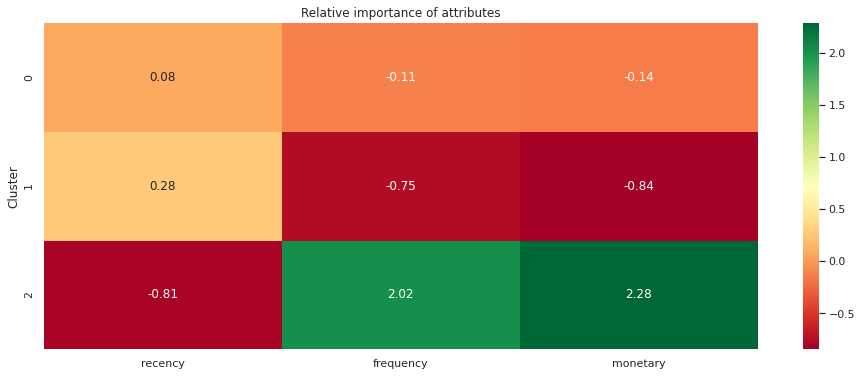

In [38]:
plt.figure(figsize=(16, 6))
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.title('Relative importance of attributes')
plt.show()

- Identify the customers in the cluster 2 and list out the customer IDs.

In [39]:
cluster2=data_rfm_k3[data_rfm_k3['Cluster']==2]
cluster2

,recency,frequency,monetary,Cluster
Customer_ID,,,,
44,30,20,152.76,2
48,60,8,259.96,2
65,31,10,72.16,2
93,30,9,140.72,2
112,150,15,449.42,2
...,...,...,...,...
22605,13,5,29.24,2
22606,9,5,40.69,2
22607,18,4,52.80,2


In [40]:
cluster2_list=[]
customer=[cluster2_list.append(x) for x in cluster2.reset_index()['Customer_ID'] if x not in cluster2_list]
print(len(cluster2_list))
print(cluster2_list)

4262
[44, 48, 65, 93, 112, 131, 162, 165, 174, 180, 183, 198, 208, 210, 228, 267, 274, 275, 279, 301, 308, 334, 339, 353, 366, 386, 395, 408, 424, 597, 598, 632, 634, 643, 651, 658, 669, 675, 678, 699, 741, 803, 853, 867, 904, 907, 911, 963, 977, 983, 985, 991, 1008, 1009, 1064, 1065, 1066, 1098, 1103, 1134, 1170, 1178, 1204, 1241, 1242, 1245, 1253, 1257, 1270, 1304, 1314, 1320, 1347, 1383, 1442, 1443, 1448, 1471, 1511, 1525, 1528, 1531, 1537, 1541, 1552, 1572, 1578, 1590, 1591, 1610, 1635, 1658, 1659, 1660, 1662, 1665, 1666, 1669, 1670, 1676, 1679, 1681, 1683, 1684, 1685, 1686, 1690, 1694, 1695, 1701, 1702, 1703, 1710, 1713, 1716, 1725, 1727, 1728, 1729, 1730, 1733, 1734, 1750, 1795, 1803, 1821, 1853, 1859, 1862, 1865, 1894, 1941, 1957, 1972, 2004, 2005, 2007, 2013, 2050, 2058, 2077, 2100, 2127, 2177, 2186, 2237, 2243, 2245, 2257, 2261, 2288, 2294, 2302, 2309, 2312, 2319, 2332, 2337, 2380, 2402, 2423, 2428, 2432, 2443, 2448, 2453, 2454, 2476, 2485, 2486, 2490, 2507, 2519, 2524, 2531, 

## 7. Conclusion

In sum, here are viewpoints as below.

1. The customers who started purchase in the early 2016 have a higher retension rate. The customers who started purchase in Feb with 6 months duration and who started purchase in Aug with 2 months duration have higher average expenditure.

2. 1,108 users are in the top 20% frequency quantile with an activity in the past two weeks. 224 users are in the top 5% quantile in recency, frequency and monetary. The IDs of the top 10 most valuable users are shown in the table above.

3. There is a significant difference between the results of the K-Means clustering and the linear quantile clustering. The K-Means clustering brings 4,262 customers together as a group, which might be too huge to target some customers for a specific marketing campaign.

Suggested further analysis.

1. Use other machine learning methods for more deeper analysis and prediction.

2. Optimize this KMeans model.

3. Other visual types to explore more insights.